In [1]:
import numpy as np
import time
import sklearn
import os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text.extractor import Ngram
from nimbusml.feature_extraction.text import NGramFeaturizer
from sklearn.feature_extraction.text import TfidfVectorizer as sklearn_TfidfVectorizer
from sklearn.decomposition import TruncatedSVD as sklearn_TruncatedSVD
from sklearn.pipeline import Pipeline as sklearn_ppl
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as sk_auc

In [2]:
def plot_roc_score(label_test, score):
    x, y, _ = roc_curve(label_test, score)
    roc_auc = sk_auc(x, y)
    
    plt.figure()
    lw = 2
    plt.plot(x, y, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
# Get input data file path from the package
Train_file = get_dataset('wiki_detox_train').as_filepath()
Test_file = get_dataset('wiki_detox_test').as_filepath()
print(os.path.basename(Train_file))
print(os.path.basename(Test_file))

train-250.wikipedia.sample.tsv
test.wikipedia.sample.tsv


In [4]:
# Loading data
# dataTrain = pd.read_csv(Train_file, encoding="ISO-8859-1", sep = "\t") # Error under py2.7 but not 3.6
dataTrain = pd.read_csv(Train_file, sep = "\t")
dataTest = pd.read_csv(Test_file, sep = "\t")

dataTrain.head()

,Sentiment,SentimentText
0,1,"==RUDE== Dude, you are rude upload that carl..."
1,1,== OK! == IM GOING TO VANDALIZE WILD ONES W...
2,1,"Stop trolling, zapatancas, calling me a lia..."
3,1,==You're cool== You seem like a really cool...
4,1,::::: Why are you threatening me? I'm not bei...


In [5]:
# Creating pipeline
t0 = time.time()

featurizer = NGramFeaturizer(word_feature_extractor=Ngram())
svd = sklearn_TruncatedSVD(random_state = 1, n_components = 400)
lr = sklearn.linear_model.LogisticRegression()
sk_ppl = sklearn_ppl([("featurizer",featurizer),
                     ("svd",svd),
                     ("lr",lr)])

In [6]:
# Training
sk_ppl.fit(dataTrain[["SentimentText"]], dataTrain["Sentiment"]) #UPDATE ONCE SERIES IS SUPPORTED FOR X!

train_time_sec = time.time() - t0
print("Training time: " + str(round(train_time_sec,2)) + "s")

Training time: 2.65s


In [7]:
# Testing
t0 = time.time()
Y_pred = sk_ppl.predict(dataTest["SentimentText"].to_frame()) #UPDATE ONCE SERIES IS SUPPORTED FOR X!
Y_prob = sk_ppl.predict_proba(dataTest["SentimentText"].to_frame())#UPDATE ONCE SERIES IS SUPPORTED FOR X!
test_time_sec = time.time() - t0
print("Testing time: " + str(round(test_time_sec,2)) + "s")

Testing time: 1.09s


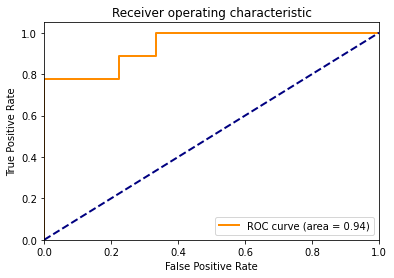

In [8]:
# Plot roc
plot_roc_score(dataTest["Sentiment"], Y_prob[:,1]);